# Practical Example

## Low dimension

The practical example consists of the stable space estimation for a multivariate time series that contains the information for several economic indicators associated with the inflation in Mexico on the period from 

In [1]:
# packages
remove(list = ls())
options(warn = -1)
suppressMessages(library(data.table))
suppressMessages(library(magrittr))
suppressMessages(library(ggplot2))
suppressMessages(library(xtable))
suppressMessages(library(GGally))

source("../source/simulations.R")
source("../source/vectorial_methods.R")
source("../source/auxiliar_methods.R")

## Economic variables associated with the inflation in Mexico

In [2]:
# Variables Inflation
dt_inflation <- data.table::fread("../databases/variables_inflation.csv")

Variables description:

- P: National Consumer Price Index
- U: Unemployment Rate
- BYM: Banknotes and Coins
- E: Nominal Exchange Rate
- R: 28-Day Interbank Interest Rate
- W: Real Wages
- PUSA: United States National Consumer Price Index 

First, we analise the covariance structure

In [3]:
options(repr.plot.width = 6, repr.plot.height =6)

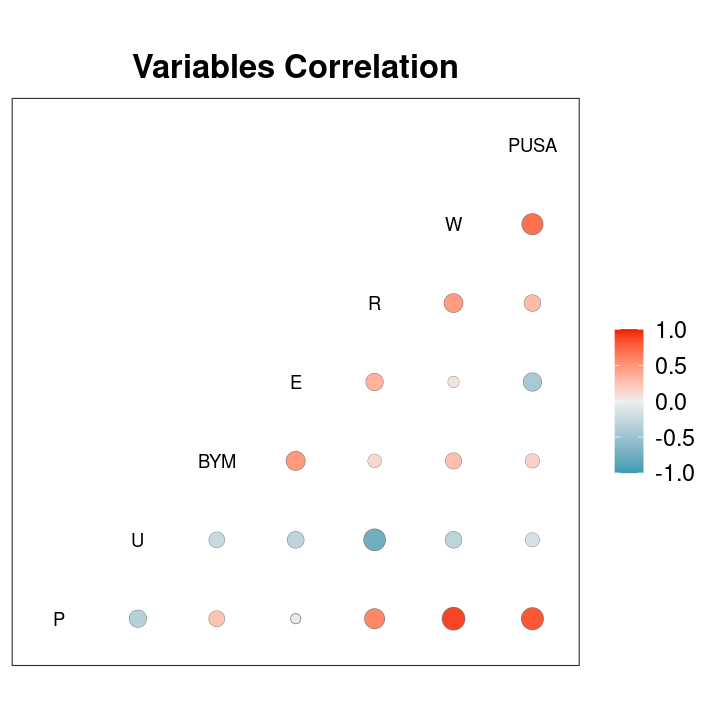

In [4]:
GGally::ggcorr(dt_inflation[,-c(1)],geom = "circle")+ggplot2::ggtitle("Variables Correlation")+mytheme

We centered the columns of the series, and we get the auxiliary blocks for the methods

In [5]:
X_inflation <- as.matrix(dt_inflation, rownames = "Date")
rownames(X_inflation) <- NULL
XX_inflation <- X_inflation[1:(nrow(X_inflation)-1),]
Y_inflation <- X_inflation[2:nrow(X_inflation),]

We check the order of integration of each variable and print the KPSS' p-value taking difference operator

In [6]:
aux <- X_inflation
I0_variables <- apply(aux,2,function(x) tseries::kpss.test(x)$p.value)
I1_variables <- apply(diff(aux),2,function(x) tseries::kpss.test(x)$p.value)
I2_variables <- apply(diff(diff(aux)),2,function(x) tseries::kpss.test(x)$p.value)

# Example list with named vectors
list <- list(X = I0_variables, DX = I1_variables,
             DDX = I2_variables)

# Convert to data frame with row names
mat_order <- do.call(cbind, list)
print(xtable(mat_order,digits = 2))

Registered S3 method overwritten by 'quantmod':
  method            from
  as.zoo.data.frame zoo 



% latex table generated in R 4.1.2 by xtable 1.8-4 package
% Wed Sep  3 21:10:28 2025
\begin{table}[ht]
\centering
\begin{tabular}{rrrr}
  \hline
 & X & DX & DDX \\ 
  \hline
P & 0.01 & 0.01 & 0.10 \\ 
  U & 0.02 & 0.10 & 0.10 \\ 
  BYM & 0.10 & 0.10 & 0.10 \\ 
  E & 0.09 & 0.10 & 0.10 \\ 
  R & 0.02 & 0.04 & 0.10 \\ 
  W & 0.01 & 0.01 & 0.10 \\ 
  PUSA & 0.06 & 0.02 & 0.10 \\ 
   \hline
\end{tabular}
\end{table}


We estimate the stable space for this multivariate time series using the methods
- Johansen
- PCA
- SPCA
- PLS

In [7]:
# PLS, PCA
basis_inflation_PLS <- basis_stable(X_inflation, method = "pls")
basis_inflation_PCA <- basis_stable(scale(X_inflation),method="pca")

# SPCA
spca_para <- 1
basis_inflation_SPCA <- basis_stable(scale(X_inflation),method = "spca", 
                                        spca_engine = "elasticnet",
                                        spca_sparse = "penalty",
                                        spca_para = spca_para)

# Johansen
basis_inflation_johansen <- basis_stable(X_inflation,method = "johansen")

We visualise the weights for each methodology

In [8]:
options(repr.plot.width = 14, repr.plot.height = 6)

In [9]:
# Tables
table_inflation_PLS <- as.matrix(basis_inflation_PLS$weights_S)
table_inflation_PCA <- as.matrix(basis_inflation_PCA$basis_S)
table_inflation_SPCA <- as.matrix(basis_inflation_SPCA$basis_S)
table_inflation_johansen <- as.matrix(basis_inflation_johansen$basis_S)
rownames(table_inflation_PLS) <- colnames(X_inflation)
rownames(table_inflation_PCA) <- colnames(X_inflation)
rownames(table_inflation_SPCA) <- colnames(X_inflation)
rownames(table_inflation_johansen) <- colnames(X_inflation)

# Compute a common color scale range
min_value <- min(table_inflation_PLS, table_inflation_PCA,
                table_inflation_SPCA, table_inflation_johansen)
max_value <- max(table_inflation_PLS, table_inflation_PCA, 
                table_inflation_SPCA, table_inflation_johansen)

# Define color palette
color_palette <- colorRampPalette(rev(RColorBrewer::brewer.pal(9, "RdYlBu")))(100)

# Generate heatmaps with common limits
gg_map_PLS <- pheatmap::pheatmap(table_inflation_PLS, cluster_rows = FALSE, cluster_cols = FALSE,
    cellwidth = 50, cellheight = 50, silent = TRUE, main = "PLS", color = color_palette,
    breaks = seq(min_value, max_value, length.out = 101))

gg_map_PCA <- pheatmap::pheatmap(table_inflation_PCA, cluster_rows = FALSE, cluster_cols = FALSE,
    cellwidth = 50, cellheight = 50, silent = TRUE, main = "PCA", color = color_palette,
    breaks = seq(min_value, max_value, length.out = 101), legend = FALSE)

gg_map_SPCA <- pheatmap::pheatmap(table_inflation_SPCA, cluster_rows = FALSE, cluster_cols = FALSE,
                                   cellwidth = 50, cellheight = 50, silent = TRUE, main = "SPCA", color = color_palette,
                                   breaks = seq(min_value, max_value, length.out = 101), legend = FALSE)

gg_map_johansen <- pheatmap::pheatmap(table_inflation_johansen, cluster_rows = FALSE, 
    cluster_cols = FALSE, cellwidth = 50, cellheight = 50, silent = TRUE, main = "Johansen", 
    color = color_palette, breaks = seq(min_value, max_value, length.out = 101),legend = FALSE)

# Combine plots
combined_plot <- cowplot::plot_grid(gg_map_johansen[[4]], gg_map_PCA[[4]], gg_map_SPCA[[4]], gg_map_PLS[[4]], 
    nrow = 1, rel_widths = c(0.25, 0.4, 0.4, 0.4))

ggsave(
  filename = "../images/Figure_4.pdf",
  plot = combined_plot,
  device = "pdf",
  width = 18,   # scale by relative widths (e.g., 1.45 units × 4 inches per unit)
  height = 8,         # set a reasonable height (adjust if needed)
  units = "in", dpi = 300)


## Projection Error

We quantify the projection error to the estimated stable space considering the first two stationary scores

In [10]:
# PLS
T_scores_PLS <- XX_inflation%*%basis_inflation_PLS$weights_S 
Y_est_PLS <- scores_rebuilt(T_scores_PLS[,1:2],Y=Y_inflation)

# PCA
T_scores_PCA <- XX_inflation%*%basis_inflation_PCA$basis_S
Y_est_PCA <- scores_rebuilt(T_scores_PCA[,1:2],Y=Y_inflation)

# SPCA
T_scores_SPCA <- XX_inflation%*%basis_inflation_SPCA$basis_S
Y_est_SPCA <- scores_rebuilt(T_scores_SPCA[,1:2],Y=Y_inflation)

# PCA with the first two components
T_scores_PCA_classic <- XX_inflation%*%cbind(basis_inflation_PCA$basis_N[,1],basis_inflation_PCA$basis_S[,1])
Y_est_PCA_classic <- scores_rebuilt(T_scores_PCA_classic[,1:2],Y=Y_inflation)

# Johansen
T_scores_johansen <- XX_inflation%*%basis_inflation_johansen$basis_S
Y_est_johansen <- scores_rebuilt(T_scores_johansen[,1], Y = Y_inflation)

Similarly, we could visualise the error or the time series studied

In [11]:
options(repr.plot.width = 12, repr.plot.height = 6)

In [12]:
dates <- dt_inflation[,Date][2:nrow(dt_inflation)]
# Color-blind safe palette (Okabe-Ito + black for observed)
custom_palette <- c(
  "Johansen"        = "#E69F00",  # orange
  "stationary PLS"  = "#56B4E9",  # sky blue
  "stationary PCA"  = "#009E73",  # bluish green
  "Observed"        = "black",    # black
  "stationary SPCA" = "#CC79A7",  # reddish purple
  # Non-stable components (newly adjusted to Okabe-Ito safe colours)
  "classic PCA"  = "#0072B2"  # blue
)

# Linetypes for better distinction
custom_linetypes <- c(
  "Observed"        = "solid",
  "Johansen"        = "dashed",
  "stationary PCA"  = "dotdash",
  "stationary PLS"  = "dotted",
  "stationary SPCA" = "twodash",
  # Non-stable components (completing your request)
  "classic PCA"  = "dashed"
)

gg_methods_fit <- plot_estimates_comparison(
                      Y_obs = Y_inflation,
                      Y_est_list = list(`stationary PLS` = Y_est_PLS$est, `stationary PCA` = Y_est_PCA$est, 
                                        `stationary SPCA` = Y_est_SPCA$est, Johansen = Y_est_johansen$est,
                                        `classic PCA` = Y_est_PCA_classic$est),
                      col_names = c("P", "W"),
                      labels = c("stationary PLS", "stationary PCA", "stationary SPCA",  "Johansen","classic PCA"),  # optional if list has names
                      dates = dates,
                      method_palette = custom_palette, 
                      method_linetypes = custom_linetypes
                    )
ggsave(
  filename = "../images/Figure_5.pdf",
  plot = gg_methods_fit,
  device = "pdf",
  width = 12,   # scale by relative widths (e.g., 1.45 units × 4 inches per unit)
  height = 8,         # set a reasonable height (adjust if needed)
  units = "in", dpi = 300)

The numerical summary of the projection error is

In [13]:
MSE <- matrix(0,ncol(Y_inflation),5) 
colnames(MSE) <- c("Johansen","classic PCA","stationary PCA", "stationary SPCA", "stationary PLS") 
rownames(MSE) <- colnames(Y_inflation)

# error estimation
MSE[,"stationary PLS"] <- VNMSE_(Y_inflation,Y_est_PLS$est)
MSE[,"stationary PCA"] <- VNMSE_(Y_inflation,Y_est_PCA$est)
MSE[,"stationary SPCA"] <- VNMSE_(Y_inflation,Y_est_SPCA$est)
MSE[,"classic PCA"] <- VNMSE_(Y_inflation,Y_est_PCA_classic$est)
MSE[,"Johansen"] <- VNMSE_(Y_inflation,Y_est_johansen$est)

We print the results for the article

In [14]:
print(xtable(MSE,digits = 2))

% latex table generated in R 4.1.2 by xtable 1.8-4 package
% Wed Sep  3 21:10:29 2025
\begin{table}[ht]
\centering
\begin{tabular}{rrrrrr}
  \hline
 & Johansen & classic PCA & stationary PCA & stationary SPCA & stationary PLS \\ 
  \hline
P & 0.91 & 0.10 & 0.26 & 0.32 & 0.26 \\ 
  U & 0.92 & 0.62 & 0.98 & 0.18 & 0.99 \\ 
  BYM & 1.00 & 0.86 & 0.79 & 0.98 & 0.80 \\ 
  E & 0.85 & 0.27 & 0.44 & 0.46 & 0.45 \\ 
  R & 0.87 & 0.41 & 0.95 & 0.14 & 0.95 \\ 
  W & 0.69 & 0.07 & 0.17 & 0.49 & 0.16 \\ 
  PUSA & 0.98 & 0.09 & 0.06 & 0.09 & 0.06 \\ 
   \hline
\end{tabular}
\end{table}


As an extra, visualisation of the observed time series

In [15]:
options(repr.plot.width = 12, repr.plot.height = 6) # plots width and heigth
dates <- dt_inflation[,Date][2:nrow(dt_inflation)]
gg_inflation_series <- vis2series(Y_inflation,Y_inflation,dates=dates,lab_X = "obs",lab_Y = "est",
            legend.position = "none",ncol=2)

ggsave(
  filename = "../images/Figure_3.pdf",
  plot = gg_inflation_series,
  device = "pdf",
  width = 12,   # scale by relative widths (e.g., 1.45 units × 4 inches per unit)
  height = 8,         # set a reasonable height (adjust if needed)
  units = "in", dpi = 300)